In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors
import matplotlib.cm as cmx
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC 
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

from Notebook_helpers import load_data
from Notebook_helpers.modeling_helpers import *

%matplotlib inline

## Read in the data

In [2]:
df, train, val, test = load_data.load_coral_data(complete=True, CV=False, convert_to_categorical=True)

### Data Prep

In [3]:
# isolate the predictors and labels for both the training and test set
train_X = train.iloc[:, 14:34]
train_y = train['Regime']

val_X = val.iloc[:, 14:34]
val_y = val['Regime']

pred_names = df.iloc[:, 14:34].columns

In [4]:
pred_names

Index(['Effluent', 'Sedimentation', 'New_Development', 'Habitat_Modification',
       'Invasive_Algae', 'Fishing_Comm_Total', 'Fishing_NonComm_Boat_Total',
       'Fishing_NonComm_Shore_Line', 'Fishing_NonComm_Shore_Net',
       'Fishing_NonComm_Shore_Spear', 'SST_CLIM_M', 'SST_STD', 'CHL_CLIM_M',
       'CHL_ANOM_F', 'PAR_CLIM_M', 'PAR_STD', 'WAV_CLIM_M', 'WAV_ANOM_F',
       'Complexity', 'Depth'],
      dtype='object')

##### Standardize the data

In [5]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(train_X.values)

# Apply transform to both the training set and the test set.
train_X = scaler.transform(train_X.values)
val_X = scaler.transform(val_X.values)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Support Vector Machines (SVMs)

### Gaussian Kernel

##### Fit the model & make predictions

In [6]:
svclassifier_gauss = SVC(kernel='rbf')  
svclassifier_gauss.fit(train_X, train_y)  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [7]:
val_pred_svm_gauss = svclassifier_gauss.predict(val_X)  

##### evaluate the performance of the model

Misclassified samples: 34
Classification Report:
              precision    recall  f1-score   support

           1       0.69      0.77      0.73        26
           2       0.75      0.75      0.75        28
           3       0.56      0.56      0.56        25
           5       0.61      0.52      0.56        21

   micro avg       0.66      0.66      0.66       100
   macro avg       0.65      0.65      0.65       100
weighted avg       0.66      0.66      0.66       100



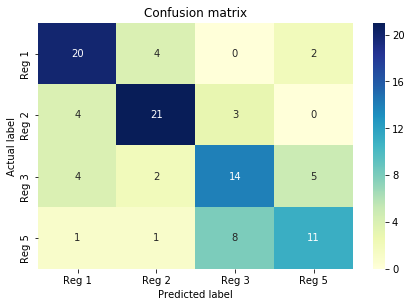

In [8]:
evaluate_performance(val_y, val_pred_svm_gauss)

### Polynomial Kernel

In [9]:
svclassifier_poly = SVC(kernel='poly')  
svclassifier_poly.fit(train_X, train_y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [10]:
val_pred_svm_poly = svclassifier_poly.predict(val_X)

Misclassified samples: 40
Classification Report:
              precision    recall  f1-score   support

           1       0.71      0.58      0.64        26
           2       0.55      0.86      0.67        28
           3       0.60      0.36      0.45        25
           5       0.60      0.57      0.59        21

   micro avg       0.60      0.60      0.60       100
   macro avg       0.61      0.59      0.59       100
weighted avg       0.61      0.60      0.59       100



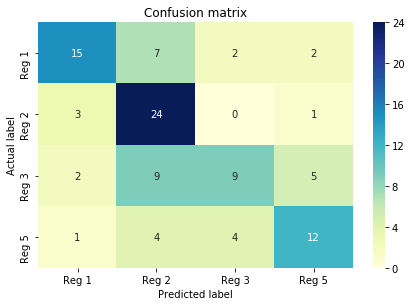

In [11]:
evaluate_performance(val_y, val_pred_svm_poly)

## Error Analysis